In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN, Birch
from collections import Counter
from sklearn.neighbors import NearestNeighbors

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    r = 6371  # radius of the Earth in kilometers

    # convert decimal degrees to radians
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    # apply the haversine formula
    a = (
        math.sin(d_lat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = round(r * c, 2)

    return distance


def lat_to_m(lat, lon):
    # approximate radius of Earth in meters
    R = 6371000

    # convert latitude and longitude to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)

    # calculate distance covered by one degree of latitude
    lat_dist = math.pi * R / 180.0

    return lat_dist * math.cos(lat_rad)


def lon_to_m(lat, lon):
    # approximate radius of Earth in meters
    R = 6371000

    # convert latitude and longitude to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)

    # calculate distance covered by one degree of longitude
    lon_dist = math.pi * R / 180.0 * math.cos(lat_rad)

    return lon_dist

# Analyzing Crime in Brooklyn

## Loading the dataset

The original dataset was downloaded from the NYC Open Data repository. I created a `parquet` to store the data in a more efficient format - this file can be download at the following link: https://www.icloud.com/iclouddrive/067VujzYLuU_4dBIez7LVxviA#NYPD%5FComplaint%5FData%5FHistoric (803.2mb).

In [3]:
tb_nyc = pd.read_parquet("data/NYPD_Complaint_Data_Historic.parquet")
tb_nyc.columns

TypeError: 'Index' object is not callable

In [4]:
tb_nyc.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

## Transforming Columns

The dataset is large - with over 7M lines - and contains a lot of information that is not relevant to the analysis. Feature engineering will be faster if done directly on the filtered dataset - the only column need to filter out the relevante cases to the analysis is the date column.

In [5]:
tb_nyc.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

### Date Columns

In [6]:
tb_nyc["CMPLNT_FR_DATE"] = pd.to_datetime(
    tb_nyc["CMPLNT_FR_DT"], format="%m/%d/%Y", errors="coerce"
)
tb_nyc["CMPLNT_TO_DATE"] = pd.to_datetime(
    tb_nyc["CMPLNT_TO_DT"], format="%m/%d/%Y", errors="coerce"
)

## Filtering data and removing outliers

In [7]:
tb_nyc = tb_nyc.dropna(subset=["CMPLNT_FR_DATE", "Latitude", "Longitude"])
mask_xxi = (
    (tb_nyc["CMPLNT_FR_DATE"].dt.year > 2000)  # Filtering 2001-Present
    & (tb_nyc["BORO_NM"] == "BROOKLYN")  # Filtering Brooklyn
    & (tb_nyc["LAW_CAT_CD"] == "FELONY")  # Only Felonies
    #    & (
    #        tb_nyc["VIC_SEX"].isin(["M", "F"])
    #    )  # Only crimes against individuals (not business nor PYNC)
    #    & (tb_nyc["JURISDICTION_CODE"] == 0)  # Only crimes handled by NYPD
    #    & (tb_nyc["CRM_ATPT_CPTD_CD"] == "COMPLETED")  # Only completed crimes
)
print(f"Filtered {np.sum(~mask_xxi)/len(~mask_xxi)*100:.2f}% of the data.")
print(f"{np.sum(mask_xxi)} lines remaining.")
tb_nyc = tb_nyc.loc[mask_xxi, :]
mask_outlier_pos = (
    (tb_nyc["Latitude"] < np.quantile(tb_nyc["Latitude"], 0.99))
    & (tb_nyc["Latitude"] > np.quantile(tb_nyc["Latitude"], 0.01))
    & (tb_nyc["Longitude"] < np.quantile(tb_nyc["Longitude"], 0.99))
    & (tb_nyc["Longitude"] > np.quantile(tb_nyc["Longitude"], 0.01))
)
print(
    f"Excluded {np.sum(~mask_outlier_pos)/len(mask_outlier_pos)*100:.2f}% of the data over spatial horizon (outliers)."
)
tb_nyc_model = tb_nyc.loc[mask_outlier_pos, :].copy()

Filtered 90.37% of the data.
751972 lines remaining.
Excluded 3.99% of the data over spatial horizon (outliers).


In [8]:
del tb_nyc

## Feature Engineering
### Cleaning Categorical Variables

We can now proceed to cleaning the categorical columns. We can substitute the `UNKNWON` code used in some columns with `NaN` values. Besides recoding NAs, we can recode categorical variable, re-econding rare levels as `np.nan`.

'CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'

In [9]:
crime_vars = [
    "OFNS_DESC",
    "PREM_TYP_DESC",
    "PARKS_NM",
    "HADEVELOPT",
    "VIC_AGE_GROUP",
    "VIC_RACE",
    "VIC_SEX",
]
tb_nyc_model["VIC_AGE_GROUP"] = np.where(
    tb_nyc_model["VIC_AGE_GROUP"] == "UNKNOWN", np.nan, tb_nyc_model["VIC_AGE_GROUP"]
)
tb_nyc_model["VIC_RACE"] = np.where(
    tb_nyc_model["VIC_RACE"] == "UNKNOWN", np.nan, tb_nyc_model["VIC_RACE"]
)
for var in crime_vars:
    tb_nyc_model[var] = tb_nyc_model[var].mask(
        tb_nyc_model[var].map(tb_nyc_model[var].value_counts(normalize=True)) < 0.01,
        np.nan,
    )

### Centering location and converting to meters

Locations is represented in two different manners: through Latitude/Longitude pairs (in the `Latitude` and `Longitude` columns) and through X/Y coordinates (in the `X_COORD_CD` and `Y_COORD_CD` columns). The X/Y coordinates are in feet, so we need to convert them to meters. We can also center the location coordinates around the mean, making this measure more interpretable.

In [10]:
tb_nyc_model["lat_demean"] = (
    tb_nyc_model["X_COORD_CD"] - tb_nyc_model["X_COORD_CD"].mean()
)
tb_nyc_model["long_demean"] = (
    tb_nyc_model["Y_COORD_CD"] - tb_nyc_model["Y_COORD_CD"].mean()
)
tb_nyc_model["lat_meters"] = tb_nyc_model["lat_demean"] / 3.28
tb_nyc_model["long_meters"] = tb_nyc_model["long_demean"] / 3.28

### Creating distance-equivalent time measure

In [11]:
tb_nyc_model["months"] = (
    (tb_nyc_model["CMPLNT_FR_DATE"] - tb_nyc_model["CMPLNT_FR_DATE"].median())
    / pd.Timedelta(1, unit="D")
) / 30.4
tb_nyc_model["year"] = tb_nyc_model["CMPLNT_FR_DATE"].dt.year
tb_nyc_model["cut_month"] = pd.qcut(tb_nyc_model["months"], 9)

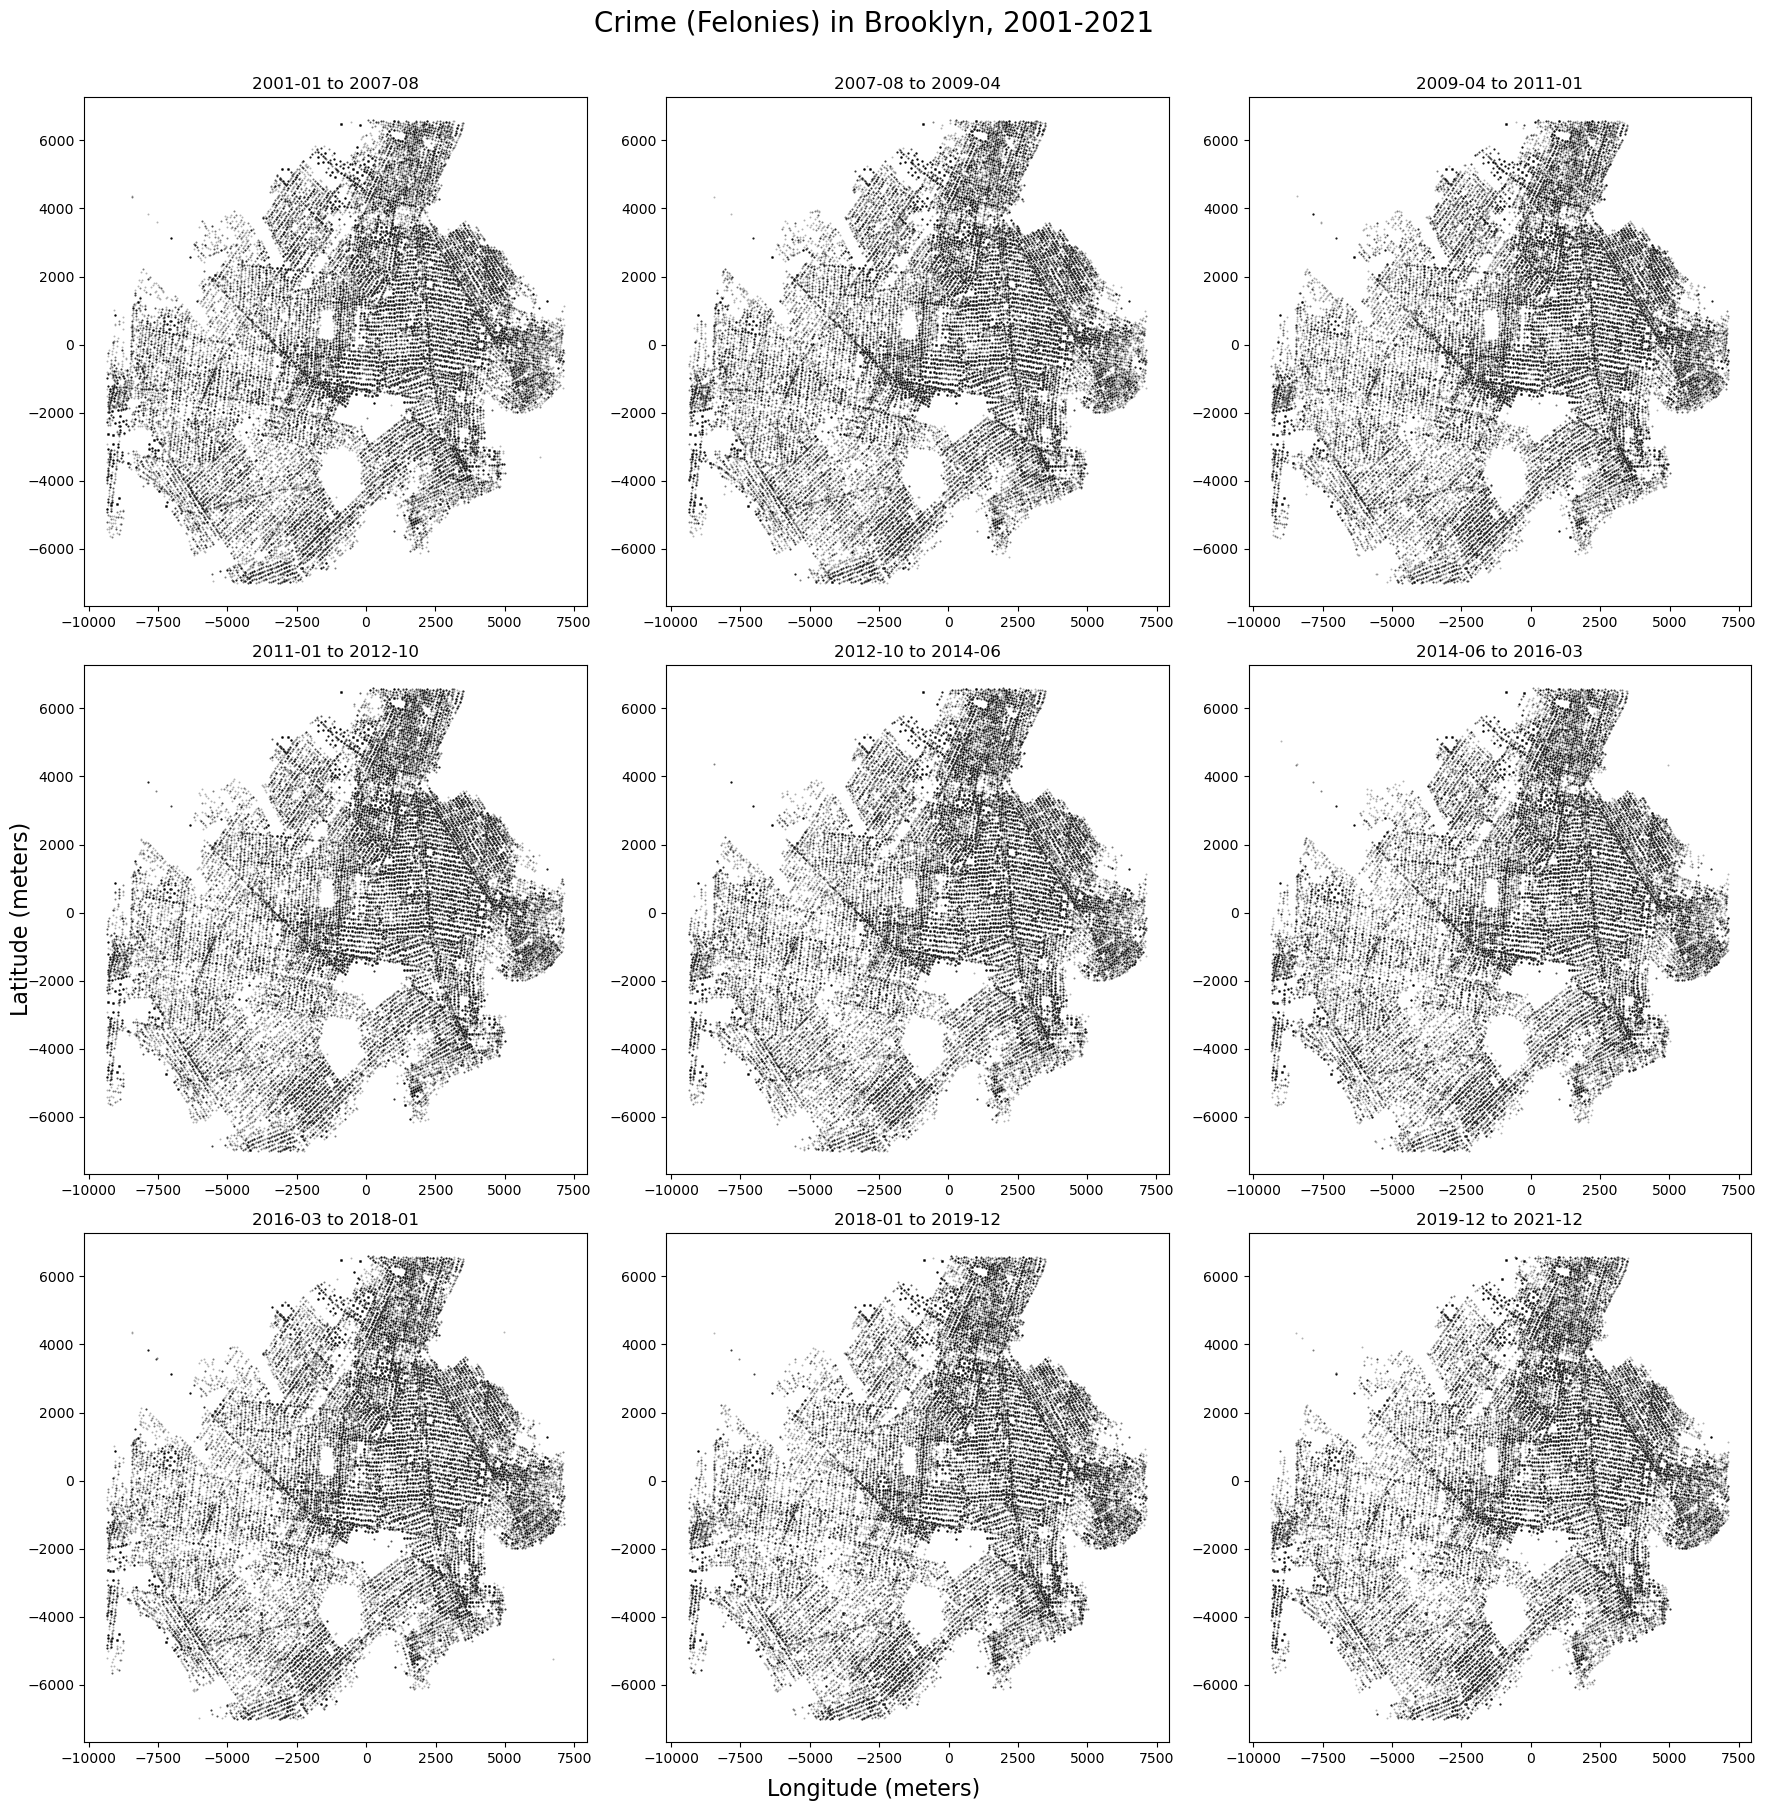

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(18, 18))
for cat, i in zip(tb_nyc_model["cut_month"].cat.categories, range(9)):
    row = i // 3
    col = i % 3
    sns.scatterplot(
        data=tb_nyc_model[tb_nyc_model["cut_month"] == cat],
        x="long_meters",
        y="lat_meters",
        color="black",
        alpha=0.3,
        s=2,
        ax=ax[row][col],
    )
    min_date = tb_nyc_model.loc[
        tb_nyc_model["cut_month"] == cat, "CMPLNT_FR_DATE"
    ].min()
    max_date = tb_nyc_model.loc[
        tb_nyc_model["cut_month"] == cat, "CMPLNT_FR_DATE"
    ].max()
    ax[row][col].set_title(f"{min_date:%Y-%m} to {max_date:%Y-%m}")
    ax[row][col].set_xlabel("")
    ax[row][col].set_ylabel("")
fig.suptitle("Crime (Felonies) in Brooklyn, 2001-2021", fontsize=20, y=1.005)
fig.supxlabel("Longitude (meters)", fontsize=16)
fig.supylabel("Latitude (meters)", fontsize=16)
fig.tight_layout()
fig.savefig("output/crime_map_brooklin_2001_2021.png", dpi=300)

## Investigating Dense Regions

In [47]:
tb_dense_quantiles = pd.DataFrame({"quantile": np.arange(0.01, 0.99, 0.01)})

for n in [50, 100, 250, 500]:
    nn = NearestNeighbors(n_neighbors=n, n_jobs=7, p=1)
    nn.fit(tb_nyc_model[["lat_meters", "long_meters"]])
    distances, index = nn.kneighbors(tb_nyc_model[["lat_meters", "long_meters"]])
    tb_dense_quantiles[f"dist_nn_{n}"] = np.quantile(
        distances[:, -1], tb_dense_quantiles["quantile"]
    )
    del nn, distances, index

for n in [50, 100, 150, 200]:
    nn = NearestNeighbors(radius=n, n_jobs=7, p=1)
    nn.fit(tb_nyc_model[["lat_meters", "long_meters"]])
    neigh = nn.radius_neighbors(
        tb_nyc_model[["lat_meters", "long_meters"]], return_distance=False
    )
    tb_dense_quantiles[f"nn_dist_{n}"] = np.quantile(
        [i.shape for i in neigh], q=tb_dense_quantiles["quantile"]
    )
    del nn, neigh

tb_dense_quantiles = tb_dense_quantiles.melt(id_vars="quantile")
tb_dense_quantiles["type"] = tb_dense_quantiles["variable"].str.split("_", expand=True)[
    0
]

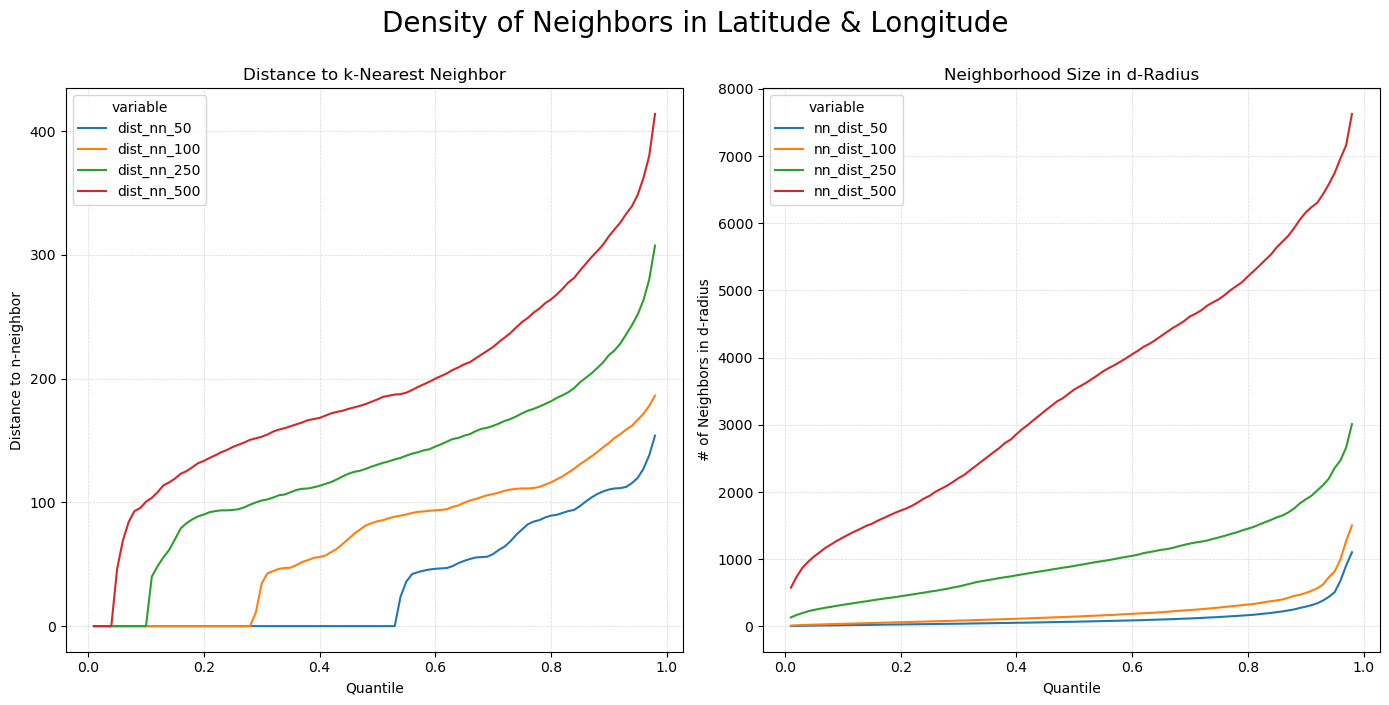

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.lineplot(
    data=tb_dense_quantiles[tb_dense_quantiles["type"] == "dist"],
    x="quantile",
    y="value",
    hue="variable",
    ax=ax[0],
)
ax[0].set_ylabel("Distance to n-neighbor")
ax[0].set_xlabel("Quantile")
ax[0].set_title("Distance to k-Nearest Neighbor")
sns.lineplot(
    data=tb_dense_quantiles[tb_dense_quantiles["type"] == "nn"],
    x="quantile",
    y="value",
    hue="variable",
    ax=ax[1],
)
ax[1].set_title("Neighborhood Size in d-Radius")
ax[1].set_ylabel("# of Neighbors in d-radius")
ax[1].set_xlabel("Quantile")

ax[0].grid(
    visible=True, which="both", axis="both", alpha=0.5, linestyle="--", linewidth=0.5
)
ax[1].grid(
    visible=True, which="both", axis="both", alpha=0.5, linestyle="--", linewidth=0.5
)
fig.suptitle("Density of Neighbors in Latitude & Longitude", fontsize=20, y=1)
fig.tight_layout()
fig.savefig("output/geographical_density_functions.png", dpi=300)

In [32]:
def calulate_equivalent_distance(month_meters):
    """
    Calculate the equivalent distance in meters for a difference
    in months, given a month-meters equivalence ratio.

    Args:
        month_meters (float): The ratio of meters to months.
    Returns:
        x (array, float):
        y (array, float): The equivalent distance in meters.
    """
    x = np.linspace(-100 / month_meters * 0.99, 100 / month_meters * 0.99, 1000)
    y = np.sqrt((100**2 - (x * month_meters) ** 2) / 2)
    return x, y


df_list = []
for ratio in np.arange(50, 301, 50):
    tb_ = pd.DataFrame()
    x, y = calulate_equivalent_distance(ratio)
    tb_["Time Distance (months)"] = x
    tb_["Equivalent Distance (meters)"] = np.sqrt(2 * y**2)
    tb_["Ratio (Meters to Months)"] = ratio
    df_list.append(tb_)

tb_ratio = pd.concat(df_list, axis=0)

Text(0.5, 1.0, 'Equivalent Distance for Different Meter/Month Ratios')

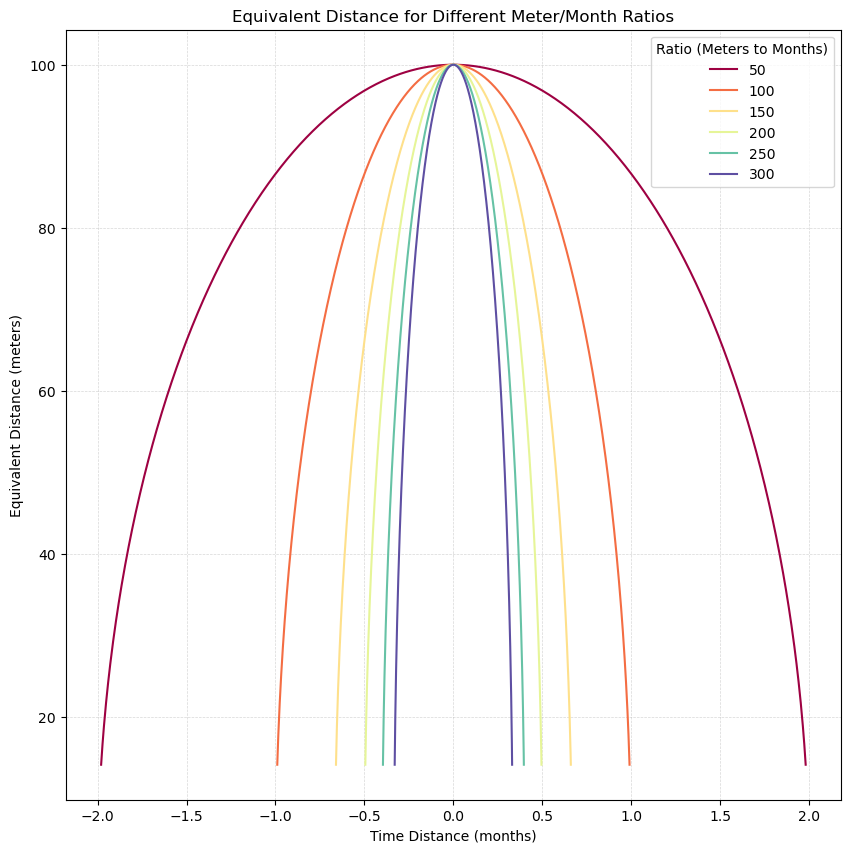

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(
    data=tb_ratio,
    x="Time Distance (months)",
    y="Equivalent Distance (meters)",
    hue="Ratio (Meters to Months)",
    palette="Spectral",
    ax=ax,
)
ax.grid(
    visible=True, which="both", axis="both", alpha=0.5, linestyle="--", linewidth=0.5
)
ax.set_title("Equivalent Distance for Different Meter/Month Ratios")
fig.savefig("output/time_distance_equivalence_ratios.png", dpi=300)

In [43]:
meter_month_ratio = 50

In [52]:
tb_nyc_model["time_meters"] = (
    tb_nyc_model["months"] * meter_month_ratio
)  # Determines relative importance of geographical distance vs. time

tb_dense_quantiles = pd.DataFrame({"quantile": np.arange(0.01, 0.99, 0.01)})
distance_ = []
for n in [50, 100, 250, 500]:
    nn = NearestNeighbors(n_neighbors=n, n_jobs=7, p=2)
    nn.fit(tb_nyc_model[["lat_meters", "long_meters", "time_meters"]])
    distances, index = nn.kneighbors(
        tb_nyc_model[["lat_meters", "long_meters", "time_meters"]]
    )
    tb_dense_quantiles[f"dist_nn_{n}"] = np.quantile(
        distances[:, -1], tb_dense_quantiles["quantile"]
    )
    distance_.append(np.round(np.quantile(distances, 0.1)/10, 0) * 10)
    del nn, distances, index

for n in np.unique(distance_):
    nn = NearestNeighbors(radius=n, n_jobs=7, p=2)
    nn.fit(tb_nyc_model[["lat_meters", "long_meters", "time_meters"]])
    neigh = nn.radius_neighbors(
        tb_nyc_model[["lat_meters", "long_meters", "time_meters"]],
        return_distance=False,
    )
    tb_dense_quantiles[f"nn_dist_{int(n)}"] = np.quantile(
        [i.shape for i in neigh], q=tb_dense_quantiles["quantile"]
    )
    del nn, neigh

tb_dense_quantiles = tb_dense_quantiles.melt(id_vars="quantile")
tb_dense_quantiles["type"] = tb_dense_quantiles["variable"].str.split("_", expand=True)[
    0
]

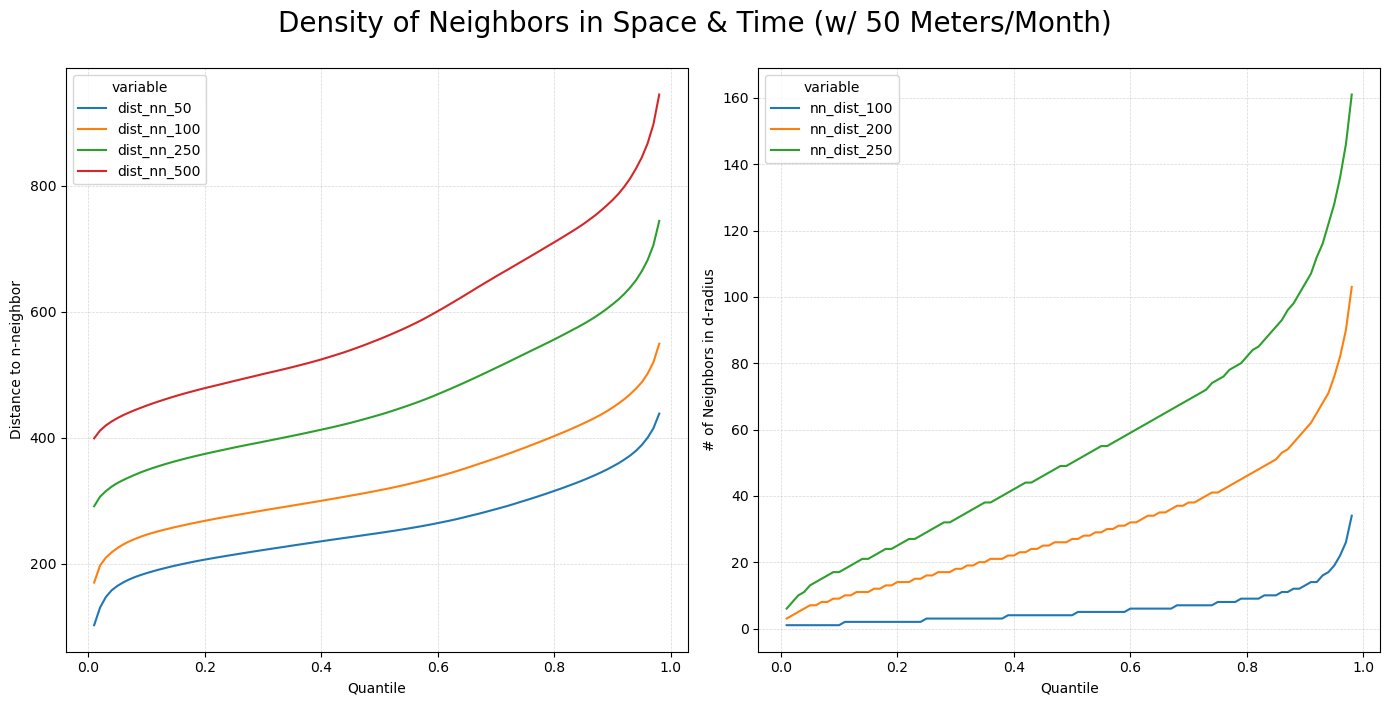

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.lineplot(
    data=tb_dense_quantiles[tb_dense_quantiles["type"] == "dist"],
    x="quantile",
    y="value",
    hue="variable",
    ax=ax[0],
)
ax[0].set_ylabel("Distance to n-neighbor")
ax[0].set_xlabel("Quantile")
ax[0].set_title("Distance to k-Nearest Neighbor")
sns.lineplot(
    data=tb_dense_quantiles[tb_dense_quantiles["type"] == "nn"],
    x="quantile",
    y="value",
    hue="variable",
    ax=ax[1],
)
ax[1].set_ylabel("# of Neighbors in d-radius")
ax[1].set_xlabel("Quantile")
ax[1].set_ylabel("# of Neighbors in d-radius")
ax[0].grid(
    visible=True, which="both", axis="both", alpha=0.5, linestyle="--", linewidth=0.5
)
ax[1].grid(
    visible=True, which="both", axis="both", alpha=0.5, linestyle="--", linewidth=0.5
)
fig.suptitle(f"Density of Neighbors in Space & Time (w/ {meter_month_ratio} Meters/Month)", fontsize=20, y=1)
fig.tight_layout()
fig.savefig("output/spatiotemporal_density_functions.png", dpi=300)

# Geographical Clustering

## Creating DBSCAN model using the BIRCHSCAN methodology

https://sappg.ufes.br/tese_drupal/tese_15224_Dissertacao_FINAL.pdf

> At first, the empirical study of δ was carried out on synthetic data sets similar to Figure 8, with the objective of better understanding the behavior of the parameter. A fixed value was defined for ε and the value of δ was varied. It can be identified that for values greater than 1, every element is considered dense or noise. Thus, there is no connection within a radius ε between any centroids at the time of applying the data set generated by the output of BIRCH and applied in DBSCAN. And for values very close to 0, practically the entire data set is obtained, which is not an interesting option. Therefore, studies were observed for the open interval between 0 and 1. - *Translation by ChatGPT*

> A princípio o estudo empírico de δ foi realizado em conjuntos de dados sintéticos semelhante ao da Figura 8, com o objetivo de compreender melhor o comportamento do parâmetro. Um valor fixo foi definido para ε e variou-se o valor de δ. Pode-se identificar que para valores maiores que 1 todo elemento é considerado como denso ou ruído. Deste modo, não existe nenhuma conexão dentro de um raio ε entre nenhum centroide no momento da aplicação do conjunto de dados gerado pela saída do BIRCH e aplicado no DBSCAN. E para valores muito próximos a 0, obtém-se praticamente o conjunto de dados inteiro, não sendo uma opção interessante. Por isso, os estudos foram observados para o intervalo aberto entre 0 e 1. - *BIRCHSCAN: Um método de aproximação do DBSCAN para grandes conjuntos de dados, Ventorim - pg. 59*

*BIRCHSCAN* is a **hybrid** clustering approach that combines the advantages of two methods: **BIRCH** and **DBSCAN**. The BIRCH algorithm is **efficient** in handling very **large datasets**, while DBSCAN is particularly effective in discovering clusters with **arbitrary shapes**, as well as being less sensitive to **noise**.

BIRCHSCAN employs the BIRCH algorithm initially to identify clusters in large datasets and then applies DBSCAN on each cluster generated by BIRCH. By breaking the large dataset into smaller sub-clusters using BIRCH, DBSCAN can be applied more efficiently on these sub-clusters. In other words, BIRCH acts as a pre-clustering step, which significantly reduces the number of comparison operations required by DBSCAN, making it more **efficient** and **scalable**.

This approach is especially useful for **large datasets** as it reduces the computational complexity of DBSCAN algorithm and improves its **scalability**. Moreover, the BIRCHSCAN procedure can handle datasets with arbitrary shapes and sizes, as well as being less sensitive to noise, which makes it a **good option** for clustering a large dataset (1M+ observations) using DBSCAN.

### Implementing the BIRCHSCAN procedure

tb_nyc_model[["lat_meters", "long_meters", "months"]].to_parquet(
    "data/tb_nyc_model.parquet"
)

In [57]:
min_samples = 50
# eps = 210
eps = 190
theta = 0.50

In [58]:
birch_fit = Birch(threshold=eps * theta, branching_factor=min_samples, n_clusters=None)
birch_fit.fit(tb_nyc_model[["lat_meters", "long_meters", "time_meters"]])
tb_nyc_model["birch_subcluster"] = birch_fit.labels_

KeyboardInterrupt: 

In [ ]:
tb_birch = pd.DataFrame(
    birch_fit.subcluster_centers_, columns=["lat_meters", "long_meters", "time_meters"]
)
tb_birch["birch_subcluster"] = birch_fit.subcluster_labels_
tb_birch["weights"] = tb_birch["birch_subcluster"].map(dict(Counter(birch_fit.labels_)))
tb_birch["cluster_size_rank"] = tb_birch["weights"].rank(ascending=False)
tb_birch["cluster_size_distrib"] = (
    tb_birch["cluster_size_rank"] / tb_birch["cluster_size_rank"].max()
)
tb_birch = tb_birch.dropna()
num_sample_cluster = sum(tb_birch["weights"] > min_samples)

Text(0.5, 0.98, 'Comparing Sampled & Original Locations')

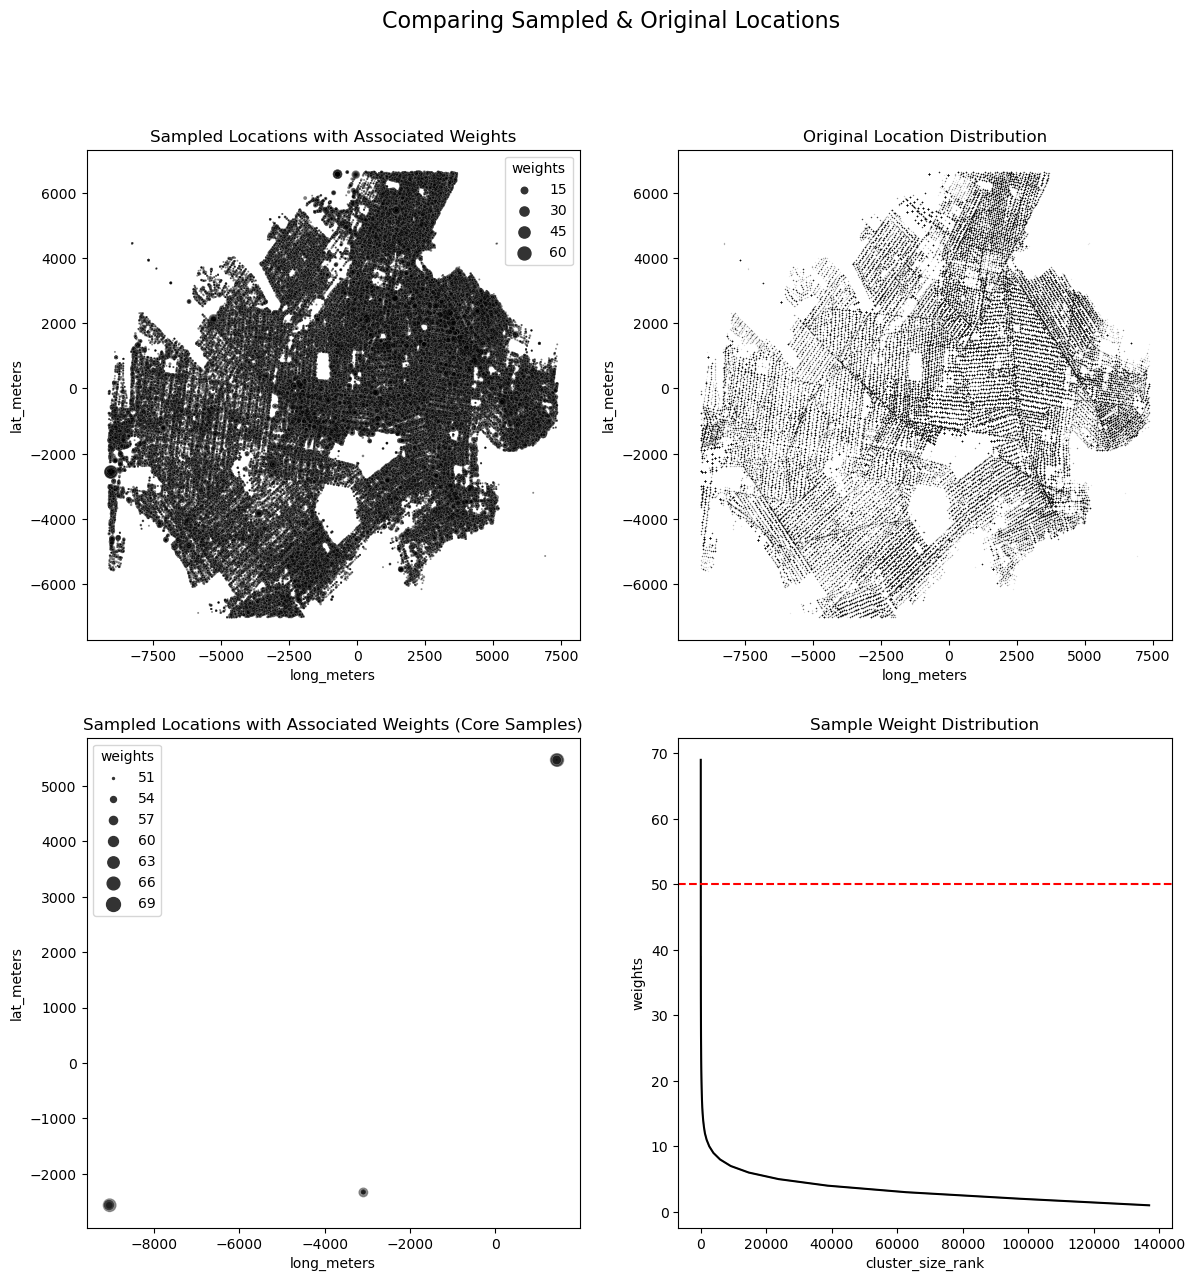

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
sns.scatterplot(
    data=tb_birch,
    x="long_meters",
    y="lat_meters",
    color="black",
    size="weights",
    sizes=(2, 100),
    alpha=0.5,
    ax=ax[0][0],
)
sns.scatterplot(
    data=tb_nyc_model,
    x="long_meters",
    y="lat_meters",
    color="black",
    alpha=0.1,
    s=1,
    ax=ax[0][1],
)
ax[0][0].set_title("Sampled Locations with Associated Weights")
ax[0][1].set_title("Original Location Distribution")
ax[0][0].set_xlabel("Longitude (meters)")
ax[0][0].set_ylabel("Latitude (meters)")
ax[0][1].set_xlabel("Longitude (meters)")
ax[0][1].set_ylabel("Latitude (meters)")
sns.scatterplot(
    data=tb_birch[tb_birch["weights"] > min_samples],
    x="long_meters",
    y="lat_meters",
    color="black",
    size="weights",
    sizes=(1, 10),
    alpha=0.5,
    ax=ax[1][0],
)
sns.lineplot(
    data=tb_birch, x="cluster_size_rank", y="weights", color="black", ax=ax[1][1]
)
ax[1][1].axhline(min_samples, color="red", linestyle="--")
ax[1][0].set_title("Sampled Locations with Associated Weights (Core Samples)")
ax[1][1].set_title("Sample Weight Distribution")
ax[1][1].annotate(
    f"Core Samples\n{num_sample_cluster/tb_birch.shape[0]*100:.2f}%",
    xy=(num_sample_cluster, min_samples * 2),
)
ax[1][0].set_xlabel("Longitude (meters)")
ax[1][0].set_ylabel("Latitude (meters)")
ax[1][1].set_xlabel("# of Locations in Cluster")
ax[1][1].set_ylabel("Cluster Rank (in Size)")
fig.supxlabel("Longitude (meters)", fontsize=16)
fig.supylabel("Latitude (meters)", fontsize=16)
fig.suptitle("Comparing Sampled & Original Locations", fontsize=16, y = 1)
fig.tight_layout()

In [28]:
db_fit = DBSCAN(eps=eps, min_samples=min_samples)
db_fit.fit(
    tb_birch[["lat_meters", "long_meters", "time_meters"]],
    sample_weight=tb_birch["weights"],
)
tb_birch["db_cluster"] = db_fit.labels_.astype(int).astype(str)
print(f"Number of Hotspots: {len(set(db_fit.labels_))}")

Number of Hotspots: 304


<Axes: xlabel='long_meters', ylabel='lat_meters'>

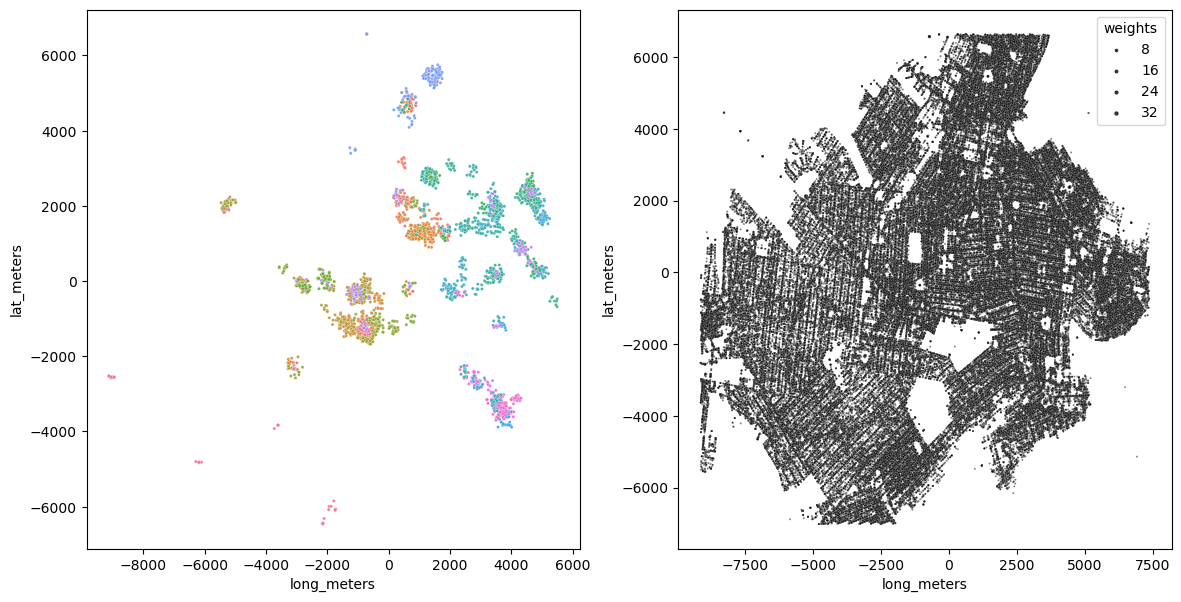

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.scatterplot(
    data=tb_birch[tb_birch["db_cluster"] != "-1"],
    x="long_meters",
    y="lat_meters",
    hue="db_cluster",
    alpha=0.9,
    s=5,
    ax=ax[0],
)
ax[0].get_legend().remove()
sns.scatterplot(
    data=tb_birch[tb_birch["db_cluster"] == "-1"],
    x="long_meters",
    y="lat_meters",
    size="weights",
    color="black",
    alpha=0.5,
    sizes=(2, 5),
    ax=ax[1],
)

In [30]:
save_vars: list[str] = [
    "CMPLNT_NUM",
    "OFNS_DESC",
    "PD_DESC",
    "CRM_ATPT_CPTD_CD",
    "LOC_OF_OCCUR_DESC",
    "PREM_TYP_DESC",
    "PARKS_NM",
    "X_COORD_CD",
    "Y_COORD_CD",
    "SUSP_AGE_GROUP",
    "SUSP_RACE",
    "SUSP_SEX",
    "TRANSIT_DISTRICT",
    "Latitude",
    "Longitude",
    "VIC_AGE_GROUP",
    "VIC_RACE",
    "VIC_SEX",
    "CMPLNT_FR_DATE",
    "lat_meters",
    "long_meters",
    "time_meters",
    "birch_subcluster",
    "db_cluster",
]

In [31]:
tb_nyc_cluster = tb_nyc_model.merge(
    tb_birch[["birch_subcluster", "db_cluster"]], on="birch_subcluster"
)
tb_nyc_cluster = tb_nyc_cluster.loc[tb_nyc_cluster["db_cluster"] != "-1", save_vars]

In [32]:
tb_nyc_cluster.to_parquet("data_output/tb_nyc_cluster.parquet")

In [33]:
tb_cluster = (
    tb_nyc_cluster.groupby("db_cluster")
    .agg(
        num_obs=("CMPLNT_NUM", "count"),
        min_date=("CMPLNT_FR_DATE", "min"),
        max_date=("CMPLNT_FR_DATE", "max"),
        center_lat=("lat_meters", "mean"),
        center_long=("long_meters", "mean"),
        std_lat=("lat_meters", "std"),
        std_long=("long_meters", "std"),
    )
    .assign(duration=lambda x: (x["max_date"] - x["min_date"]) / pd.Timedelta(days=1))
    .sort_values("max_date", ascending=False)
)
tb_cluster["avg_crime_day"] = tb_cluster["num_obs"] / tb_cluster["duration"]
tb_cluster["log_avg_crime_day"] = np.log(tb_cluster["avg_crime_day"])
tb_cluster["start_date_group"] = pd.qcut(tb_cluster["min_date"], 9)

<Axes: xlabel='duration', ylabel='Count'>

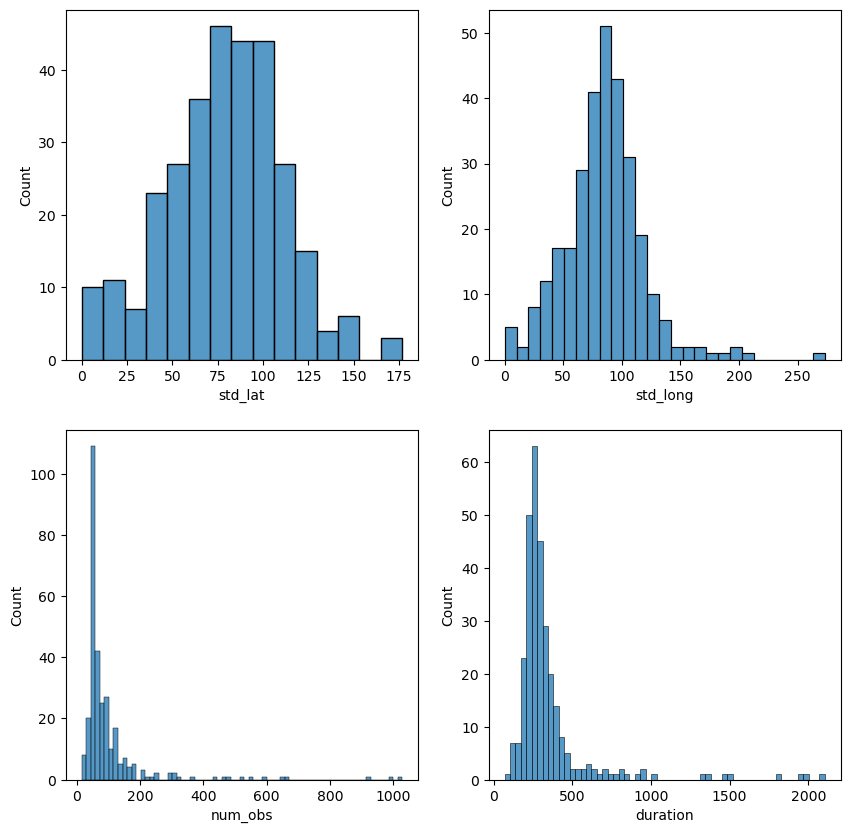

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(data=tb_cluster, x="std_lat", ax=ax[0][0])
sns.histplot(data=tb_cluster, x="std_long", ax=ax[0][1])
sns.histplot(data=tb_cluster, x="num_obs", ax=ax[1][0])
sns.histplot(data=tb_cluster, x="duration", ax=ax[1][1])

<Axes: xlabel='duration'>

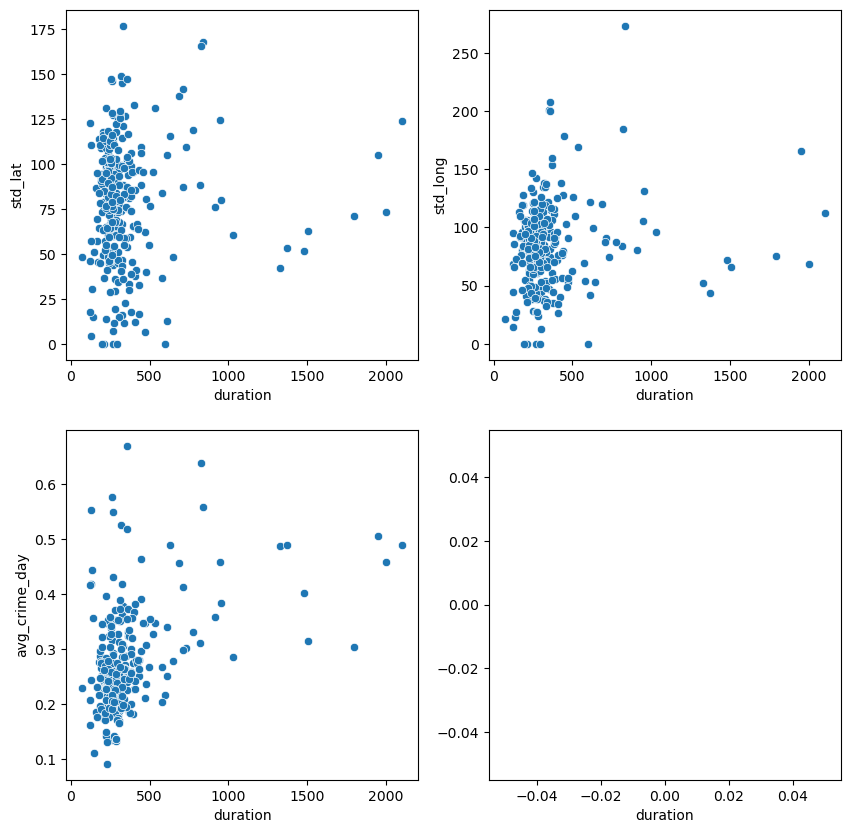

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(data=tb_cluster, x="duration", y="std_lat", ax=ax[0][0])
sns.scatterplot(data=tb_cluster, x="duration", y="std_long", ax=ax[0][1])
sns.scatterplot(data=tb_cluster, x="duration", y="avg_crime_day", ax=ax[1][0])

sns.scatterplot(data=tb_cluster, x="duration", ax=ax[1][1])

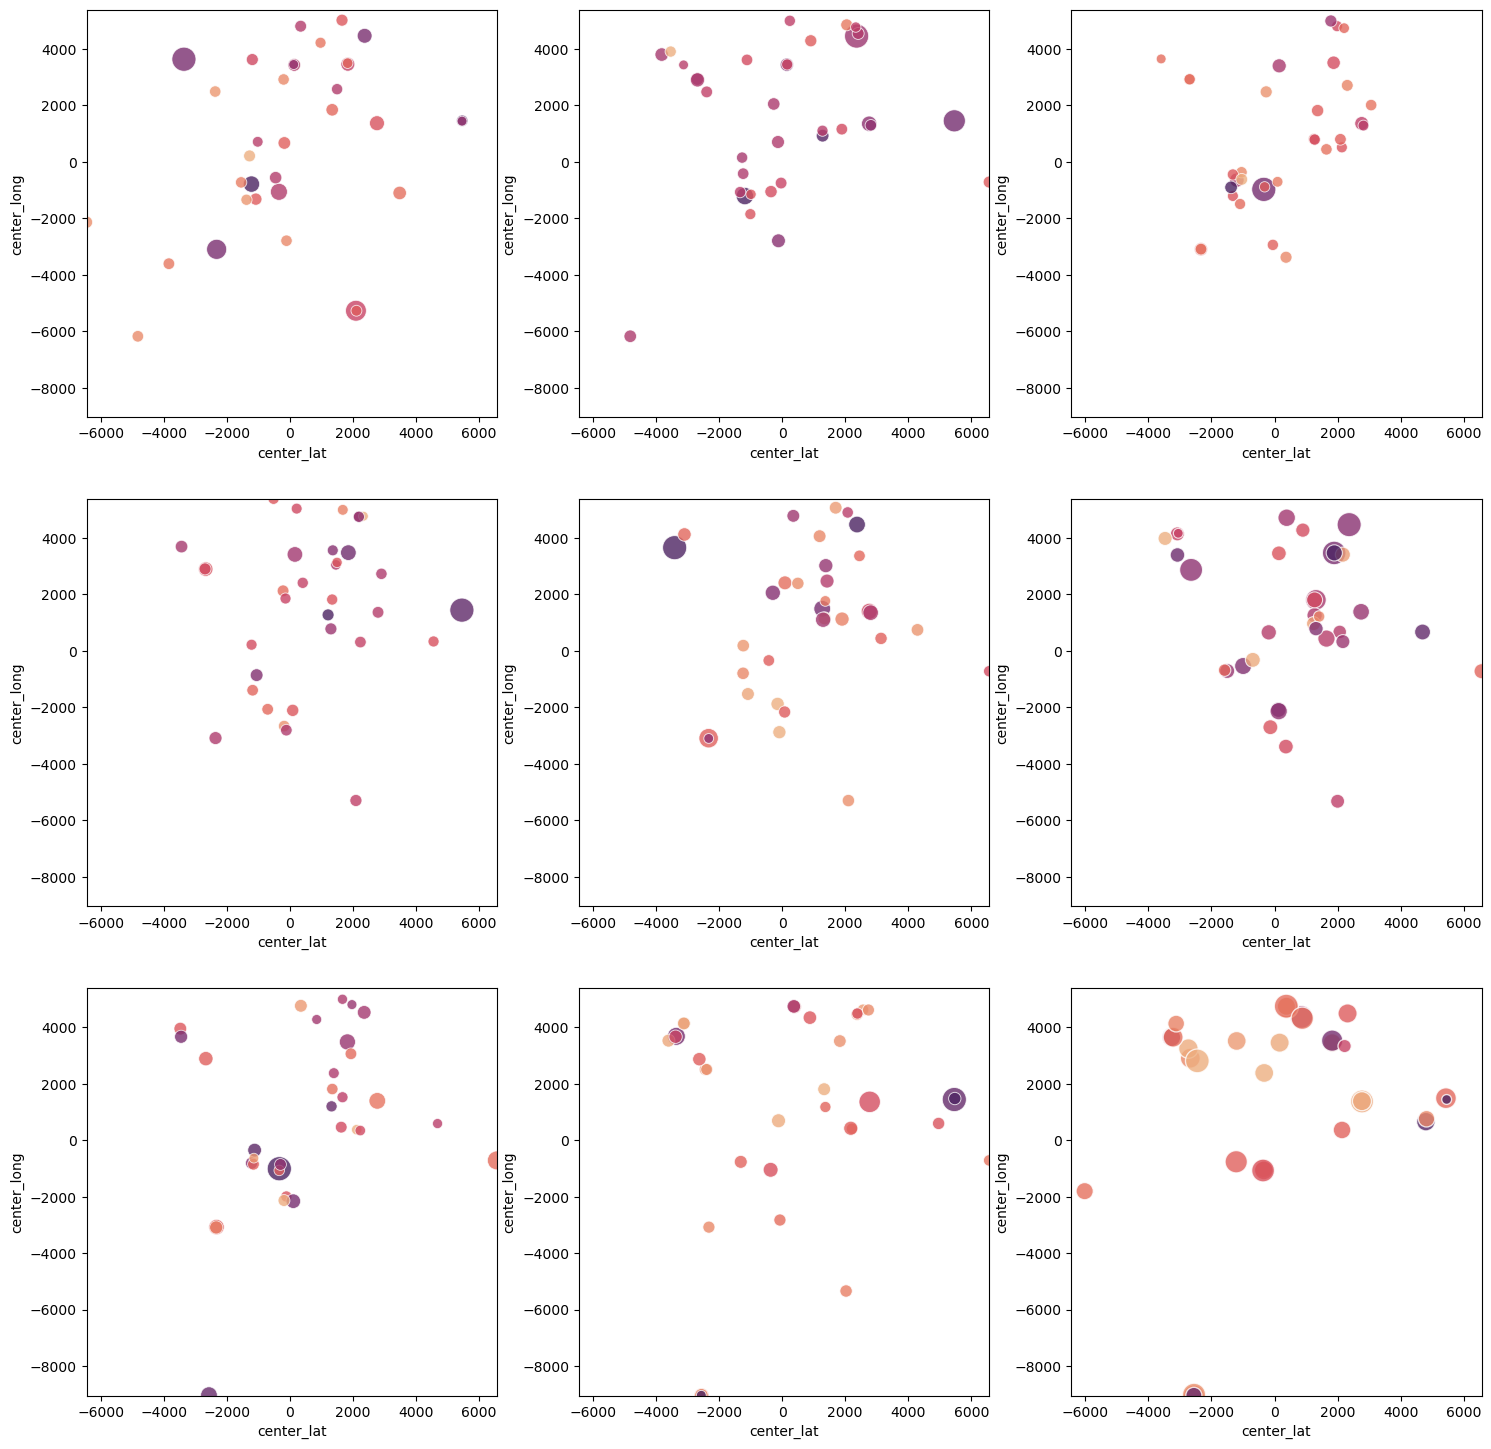

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(18, 18))
xmin = tb_cluster["center_lat"].min()
xmax = tb_cluster["center_lat"].max()

ymin = tb_cluster["center_long"].min()
ymax = tb_cluster["center_long"].max()
for cat, i in zip(tb_cluster["start_date_group"].cat.categories, range(9)):
    row = i // 3
    col = i % 3
    data = tb_cluster[tb_cluster["start_date_group"] == cat]
    sns.scatterplot(
        data=data,
        x="center_lat",
        y="center_long",
        size="duration",
        hue="log_avg_crime_day",
        palette="flare",
        sizes=(50, 300),
        alpha=0.8,
        ax=ax[row][col],
    )
    ax[row][col].set_xlim(xmin, xmax)
    ax[row][col].set_ylim(ymin, ymax)
    ax[row][col].get_legend().remove()

In [37]:
tb_cluster.sort_values("duration", ascending=False).head()

num_obs   min_date   max_date   center_lat  center_long   
db_cluster                                                            
138            1028 2006-03-04 2011-12-08 -3360.128741  3632.630236  \
186             915 2010-11-12 2016-05-04  5460.245877  1446.106635   
31              986 2009-05-29 2014-10-01  -340.764687  -977.790516   
118             545 2007-12-10 2012-11-08  2362.315799  4452.155429   
52              473 2006-06-09 2010-07-24  2098.710680 -5276.859463   

               std_lat    std_long  duration  avg_crime_day   
db_cluster                                                    
138         124.064686  112.043486    2105.0       0.488361  \
186          73.129923   68.847340    2000.0       0.457500   
31          104.785521  165.609698    1951.0       0.505382   
118          70.757078   75.282473    1795.0       0.303621   
52           62.926910   66.389110    1506.0       0.314077   

            log_avg_crime_day   
db_cluster                      
138                 -0.716700  \
186                 -0.781978   
31                  -0.682441   
118                 -1.191975   
52                  -1.158117   

                                             start_date_group  
db_cluster                                                     
138         (2005-06-30 23:59:59.999999999, 2006-07-11 05:...  
186                (2010-05-23 08:00:00, 2011-10-15 08:00:00]  
31                 (2008-05-21 02:40:00, 2010-05-23 08:00:00]  
118                (2006-07-11 05:20:00, 2008-05-21 02:40:00]  
52          (2005-06-30 23:59:59.999999999, 2006-07-11 05:...

In [57]:
tb_clu_336 = tb_nyc_cluster.loc[tb_nyc_cluster["db_cluster"] == "138", :].copy()
tb_clu_336 = tb_clu_336.sort_values("CMPLNT_FR_DATE")
tb_clu_336["days_since_last_crime"] = tb_clu_336[
    "CMPLNT_FR_DATE"
].diff() / pd.Timedelta(days=1)
tb_clu_336["mm_lat_meters"] = tb_clu_336["lat_meters"].rolling(30).mean()
tb_clu_336["mm_long_meters"] = tb_clu_336["long_meters"].rolling(30).mean()
tb_clu_336["std_lat_meters"] = tb_clu_336["lat_meters"].rolling(30).std()
tb_clu_336["std_long_meters"] = tb_clu_336["long_meters"].rolling(30).std()

<Axes: xlabel='CMPLNT_FR_DATE', ylabel='std_long_meters'>

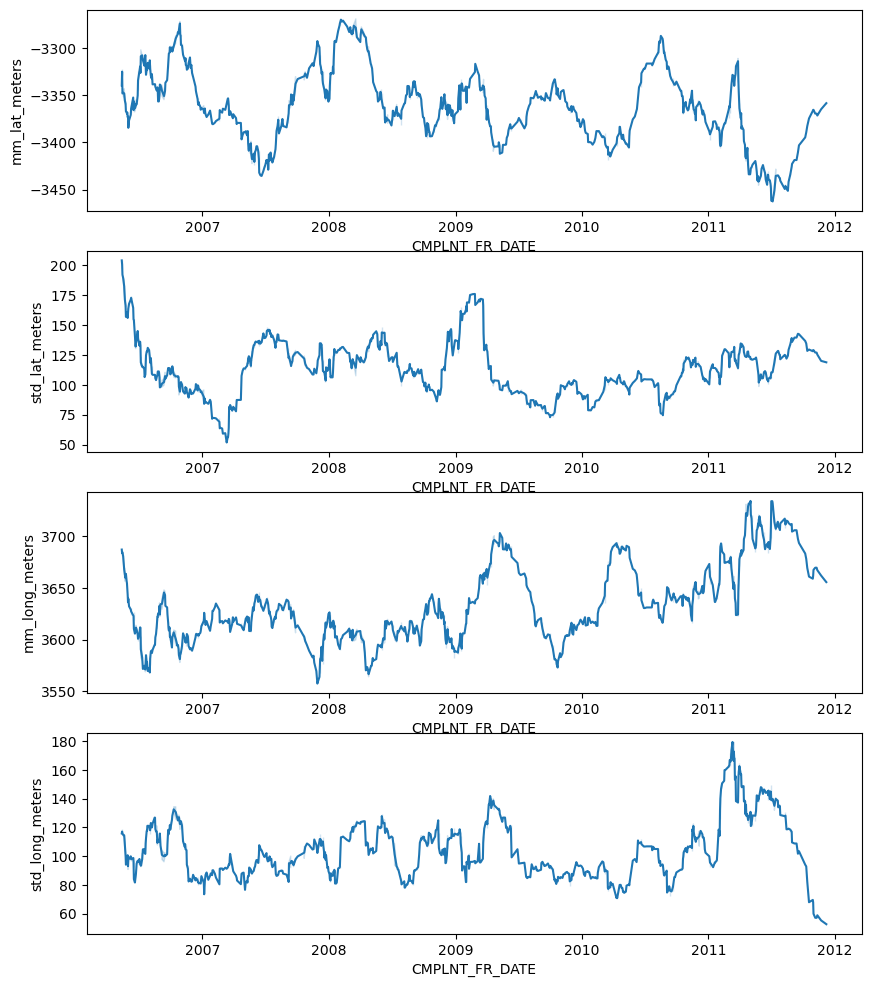

In [48]:
fig, ax = plt.subplots(4, 1, figsize=(10, 12))
sns.lineplot(data=tb_clu_336, x="CMPLNT_FR_DATE", y="mm_lat_meters", ax=ax[0])
sns.lineplot(data=tb_clu_336, x="CMPLNT_FR_DATE", y="std_lat_meters", ax=ax[1])
sns.lineplot(data=tb_clu_336, x="CMPLNT_FR_DATE", y="mm_long_meters", ax=ax[2])
sns.lineplot(data=tb_clu_336, x="CMPLNT_FR_DATE", y="std_long_meters", ax=ax[3])

In [60]:
tb_clu_336.dropna(subset="days_since_last_crime").to_parquet(
    "data_output/tb_clu_138.parquet"
)

In [114]:
tb_ts_clu = pd.DataFrame(
    {
        "date": pd.date_range(
            tb_clu_336["CMPLNT_FR_DATE"].min(),
            tb_clu_336["CMPLNT_FR_DATE"].max(),
            freq="D",
        )
    }
)
tb_ts_clu = tb_ts_clu.merge(
    tb_clu_336[["CMPLNT_FR_DATE", "lat_meters", "long_meters"]],
    left_on="date",
    right_on="CMPLNT_FR_DATE",
    how="left",
)
tb_ts_clu = (
    tb_ts_clu.groupby("date")
    .agg(
        num_crimes=("CMPLNT_FR_DATE", "count"),
        lat_meters=("lat_meters", "mean"),
        long_meters=("long_meters", "mean"),
    )
    .reset_index()
)
tb_ts_clu["num_crimes_30"] = tb_ts_clu.rolling(
    window=pd.Timedelta("90 days"), on="date"
).sum()["num_crimes"]
tb_ts_clu["lat_meters_30"] = tb_ts_clu.rolling(
    window=pd.Timedelta("90 days"), on="date"
).mean()["lat_meters"]
tb_ts_clu["long_meters_30"] = tb_ts_clu.rolling(
    window=pd.Timedelta("90 days"), on="date"
).mean()["long_meters"]
tb_ts_clu = tb_ts_clu.loc[
    tb_ts_clu["date"] > (tb_clu_336["CMPLNT_FR_DATE"].min() + pd.Timedelta("30 days")),
    ["date", "num_crimes_30", "lat_meters_30", "long_meters_30"],
]

In [115]:
tb_ts_clu.to_parquet("data_output/tb_ts_clu_138.parquet")

In [125]:
tb_ts_clu["days_since_start"] = (
    tb_ts_clu["date"] - tb_ts_clu["date"].min()
) / pd.Timedelta("1 day")

<Axes: xlabel='long_meters_30', ylabel='lat_meters_30'>

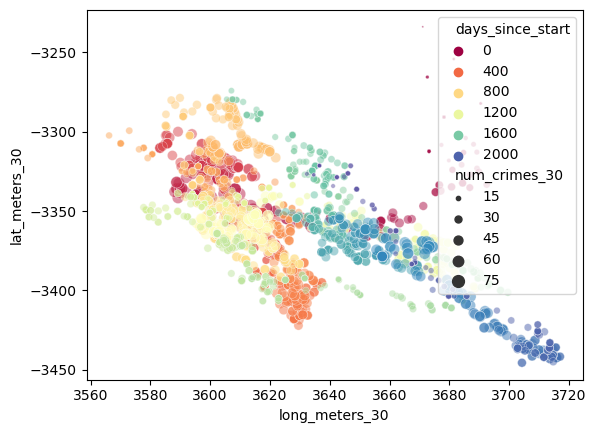

In [128]:
sns.scatterplot(
    data=tb_ts_clu,
    x="long_meters_30",
    y="lat_meters_30",
    size="num_crimes_30",
    hue="days_since_start",
    palette="Spectral",
    sizes=(2, 80),
    alpha=0.5,
)

<Axes: xlabel='date', ylabel='long_meters_30'>

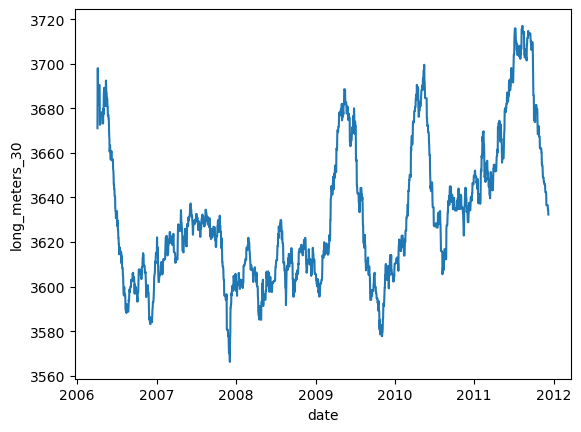

In [120]:
sns.lineplot(data=tb_ts_clu, x="date", y="long_meters_30")